In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
import numpy as np

import matplotlib as mpl

from IPython.display import clear_output
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing import image
tf.executing_eagerly()

True

In [0]:
class DeepDreamNetwork:
  def __init__(self, name, weights_path, layer_names):
    if name == 'InceptionV3':
      self.base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
    if name == 'VGG16':
      self.base_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet')

    if weights_path is not None:
      self.base_model.load_weights(weights_path)

    if layer_names is not None:
      self.create_dream_model(layer_names)
    else:
      self.create_dream_model()

  # Download an image and read it into a NumPy array.
  def download(self, url, target_size=None):
    name = url.split('/')[-1]
    image_path = tf.keras.utils.get_file(name, origin=url)
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=target_size)
    img = np.array(img)
    return img

  # Normalize an image
  def deprocess(self, img):
    img = 255*(img + 1.0)/2.0
    return tf.cast(img, tf.uint8)

  # Display an image
  def show(self, img):
    plt.figure(figsize=(12,12))
    plt.grid(False)
    plt.axis('off')
    plt.imshow(img)
    plt.show()

  def set_image_by_url(self, url, target_size=[225, 375]):
    # Downsizing the image makes it easier to work with.
    self.input_img = self.download(url, target_size=target_size)
    self.input_img = np.array(self.input_img)

    self.show(self.input_img)
    return self.input_img

  def create_dream_model(self, names = ['mixed3', 'mixed5']):
    # Maximize the activations of these layers
    layers = [self.base_model.get_layer(name).output for name in names]

    # Create the feature extraction model
    self.dream_model = tf.keras.Model(inputs=self.base_model.input, outputs=layers)

  def calc_loss(self, img, model):
    # Pass forward the image through the model to retrieve the activations.
    # Converts the image into a batch of size 1.
    img_batch = tf.expand_dims(img, axis=0)
    layer_activations = model(img_batch)

    losses = []
    for act in layer_activations:
      loss = tf.math.reduce_mean(act)
      losses.append(loss)

    return  tf.reduce_sum(losses)

  @tf.function
  def deepdream(self, model, img, step_size):
    with tf.GradientTape() as tape:
      # This needs gradients relative to `img`
      # `GradientTape` only watches `tf.Variable`s by default
      tape.watch(img)
      loss = self.calc_loss(img, model)

    # Calculate the gradient of the loss with respect to the pixels of the input image.
    gradients = tape.gradient(loss, img)

    # Normalize the gradients.
    gradients /= tf.math.reduce_std(gradients) + 1e-8 
    
    # In gradient ascent, the "loss" is maximized so that the input image increasingly "excites" the layers.
    # You can update the image by directly adding the gradients (because they're the same shape!)
    img = img + gradients*step_size
    img = tf.clip_by_value(img, -1, 1)

    return loss, img

  def run_deep_dream_simple(self, img, steps=100, step_size=0.01):
    # Convert from uint8 to the range expected by the model.
    img = tf.keras.applications.inception_v3.preprocess_input(img)

    for step in range(steps):
      loss, img = self.deepdream(self.dream_model, img, step_size)
      print(step)
      if step % 100 == 0:
        clear_output(wait=True)
        self.show(self.deprocess(img))
        print ("Step {}, loss {}".format(step, loss))


    result = self.deprocess(img)
    clear_output(wait=True)
    self.show(result)
    self.output_img = result

    return result

  def random_roll(self, img, maxroll):
    # Randomly shift the image to avoid tiled boundaries.
    shift = tf.random.uniform(shape=[2], minval=-maxroll, maxval=maxroll, dtype=tf.int32)
    shift_down, shift_right = shift[0],shift[1] 
    img_rolled = tf.roll(tf.roll(img, shift_right, axis=1), shift_down, axis=0)
    return shift_down, shift_right, img_rolled

  @tf.function
  def get_tiled_gradients(self, model, img, tile_size=512):
    shift_down, shift_right, img_rolled = self.random_roll(img, tile_size)

    # Initialize the image gradients to zero.
    gradients = tf.zeros_like(img_rolled)

    for x in tf.range(0, img_rolled.shape[0], tile_size):
      for y in tf.range(0, img_rolled.shape[1], tile_size):
        # Calculate the gradients for this tile.
        with tf.GradientTape() as tape:
          # This needs gradients relative to `img_rolled`.
          # `GradientTape` only watches `tf.Variable`s by default.
          tape.watch(img_rolled)

          # Extract a tile out of the image.
          img_tile = img_rolled[x:x+tile_size, y:y+tile_size]
          loss = self.calc_loss(img_tile, model)

        # Update the image gradients for this tile.
        gradients = gradients + tape.gradient(loss, img_rolled)

    # Undo the random shift applied to the image and its gradients.
    gradients = tf.roll(tf.roll(gradients, -shift_right, axis=1), -shift_down, axis=0)

    # Normalize the gradients.
    gradients /= tf.math.reduce_std(gradients) + 1e-8 

    return gradients

  def run_deep_dream_with_octaves(self, img, steps_per_octave=100, step_size=0.01, 
                                   num_octaves=3, octave_scale=1.3):
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = tf.keras.applications.inception_v3.preprocess_input(img)

    for octave in range(num_octaves):
      # Scale the image based on the octave
      if octave>0:
        new_size = tf.cast(tf.convert_to_tensor(img.shape[:2]), tf.float32)*octave_scale
        img = tf.image.resize(img, tf.cast(new_size, tf.int32))

      for step in range(steps_per_octave):
        gradients = self.get_tiled_gradients(self.dream_model, img)
        img = img + gradients*step_size
        img = tf.clip_by_value(img, -1, 1)
        print(step)
        if step % 10 == 0:
          clear_output(wait=True)
          self.show(self.deprocess(img))
          print ("Octave {}, Step {}".format(octave, step))
    
    clear_output(wait=True)
    result = self.deprocess(img)
    self.show(result)

    self.output_img = result

    return result

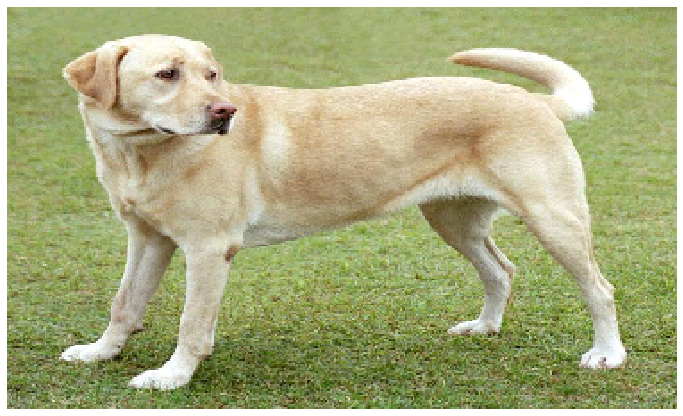

In [0]:
url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg'
img = DDNetwork.set_image_by_url(url)

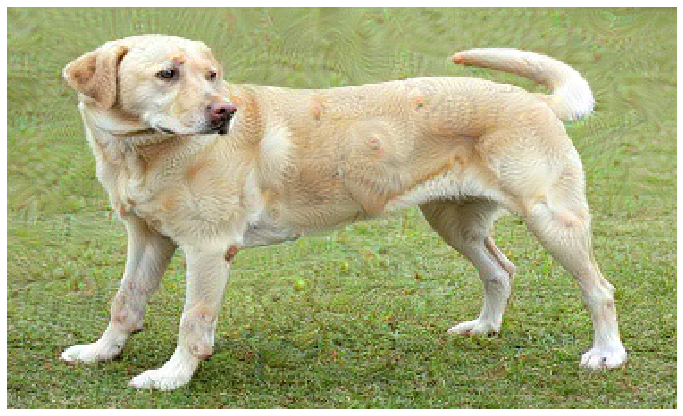

Step 100, loss 1.545411229133606


KeyboardInterrupt: ignored

In [0]:
DDNetwork = DeepDreamNetwork('InceptionV3', None, ['mixed3', 'mixed5'])
dream_img = DDNetwork.run_deep_dream_simple(img=img, steps=800, step_size=0.001)


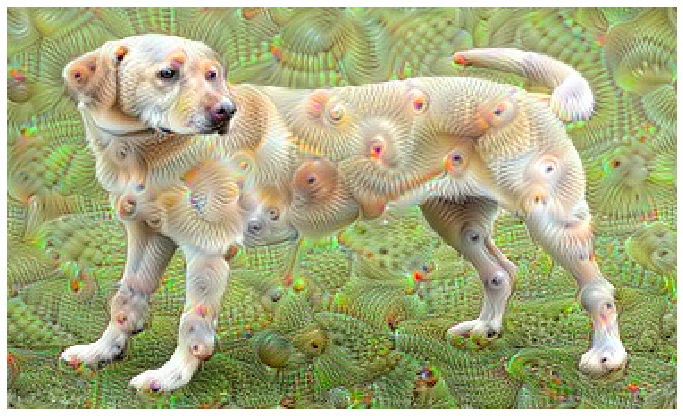

Octave 0, Step 70
71


KeyboardInterrupt: ignored

In [0]:
DDNetwork = DeepDreamNetwork('InceptionV3', None, None)
dream_img = DDNetwork.run_deep_dream_with_octaves(img=img, step_size=0.01)

clear_output()
DDNetwork.show(img)
DDNetwork.show(DDNetwork.output_img)